# Using different fitting backends
`Moose` itself provides no fitting methods, it simply tries to give you the tools to integrate it in your own workflow.

While most examples use the [lmfit](https://lmfit.github.io/lmfit-py/) package to demonstrate fitting spectra, you can also use `scipy.optimize.curve_fit` directly.

Under the hood `lmfit` also relies on `scipy`, but their API is different for specifying fit parameters, initial values, bounds, etc.


In [4]:
import Moose
import lmfit
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

df = pd.read_csv('./N2SPS/20220302_s01_sig.cam', sep='\t', header=1, names=['Wavelength', 'I'])
df['Norm'] = (df['I']-df['I'].min())/(df['I'].max()-df['I'].min())

db = Moose.query_DB('N2CB', (320,340))
model = lmfit.Model(Moose.model_for_fit, sim_db = db)
params = lmfit.create_params(**Moose.default_params)


In [5]:
result_lmfit = model.fit(df['Norm'].values, x = df['Wavelength'].values, params=params)
result_scipy =curve_fit(partial(Moose.model_for_fit, sim_db=db), xdata=df['Wavelength'].values, ydata=df['Norm'].values, p0=[v['value'] for v in Moose.default_params.values()], bounds = ([params[p].min for p in params],[params[p].max for p in params])) 

Text(0.5, 0, '$\\lambda$ (nm)')

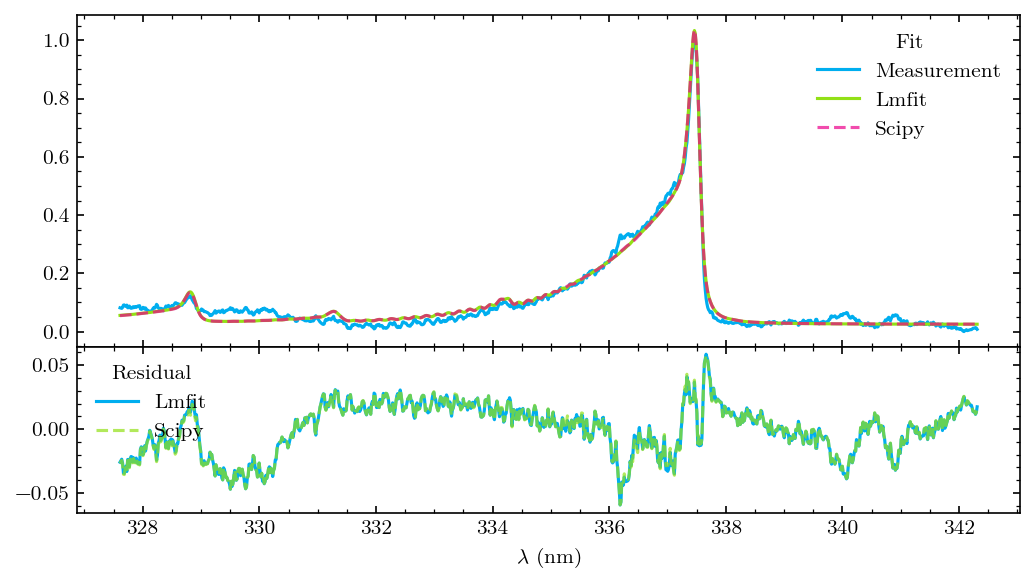

In [6]:
fig, ax = plt.subplots(2,1, sharex=True, tight_layout=True, gridspec_kw={'hspace':0, 'height_ratios':[2,1]})
df.plot(x='Wavelength', y='Norm', ax=ax[0], label='Measurement')
ax[0].plot(df['Wavelength'], result_lmfit.best_fit, label='Lmfit')
ax[0].plot(df['Wavelength'], Moose.model_for_fit(df['Wavelength'].values, *result_scipy[0], sim_db=db), label='Scipy', ls='--', alpha=0.7)
ax[0].legend(title='Fit')

# ax[1].plot(df['Wavelength'], result_lmfit.residual - (Moose.model_for_fit(df['Wavelength'].values, *result_scipy[0], sim_db=db)-df['Norm']), label='Difference')
ax[1].plot(df['Wavelength'], result_lmfit.residual, label='Lmfit')
ax[1].plot(df['Wavelength'], Moose.model_for_fit(df['Wavelength'].values, *result_scipy[0], sim_db=db)-df['Norm'], label='Scipy', alpha=0.7, ls='--')
ax[1].legend(title='Residual')
ax[1].set_xlabel('$\lambda$ (nm)')

In [7]:
%timeit result_lmfit = model.fit(df['Norm'].values, x = df['Wavelength'].values, params=params)
%timeit result_scipy = curve_fit(partial(Moose.model_for_fit, sim_db=db), xdata=df['Wavelength'].values, ydata=df['Norm'].values, p0=[params[p].value for p in params if params[p].vary is True],bounds = ([params[p].min for p in params if params[p].vary is True],[params[p].max for p in params if params[p].vary is True]))

549 ms ± 7.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
414 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
